In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm
from gcurve_parser import get_curve

# Формулировка проблемы

Специфики работы страховой компании предполагает наличие значительного портфеля в fixed-income инструментах (облигации, депозиты). Поэтому для целей бюджетного планирования и управления рисками (стресс-теста) необходимо решить задачу прогнозирования уровней процентных ставок, которые уже в свою очередь используются для:
* Прогнозирования стоимости портфеля/переоценки в стрессовых сценария и базовых сценариях
* Прогнозирование уровня рискового капитала (Риск 1 в методологии 781-п), который участвует в расчёте аналога норматива достаточности капитала - Нормативном соотношении (подробнее Положение ЦБ 781-п)

Все эти показатели напрямую зависят от уровней ключевой ставок на всей КБД кривой. Далее будет описан подход к прогнозирования распределения ставок на кривой.

# Загрузка истории теноров КБД-Мосбиржи и ключевой ставки
Метод парсит данные по КБД кривой, убран в отдельный файл.
Загружаем историю с 2018 года. Данные будут спользоваться для калибровки "в историю".

In [2]:
#g_curve = get_curve('2014-01-30', '2024-05-31')
#g_curve.to_csv('g-curve.csv')

g_curve_history = pd.read_csv('g-curve.csv')
g_curve_history['TRADEDATE'] = pd.to_datetime(g_curve_history['TRADEDATE'])
keyrate = pd.read_excel('rub_keyrate.xlsx') # не нашел простого способа парсить ключ-ставку, просто скачал в эксель

g_curve_history = g_curve_history.merge(keyrate, on='TRADEDATE', how='left').ffill().dropna()


<AxesSubplot:title={'center':'Доходности КБД, %'}, xlabel='TRADEDATE'>

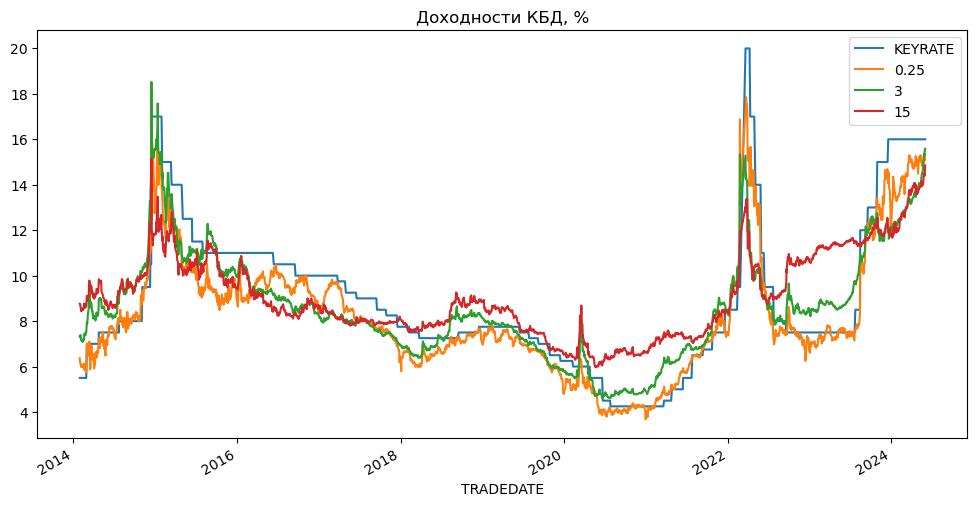

In [3]:
g_curve_history.plot(x='TRADEDATE', y=['KEYRATE', '0.25', '3', '15'], figsize=(12, 6), title='Доходности КБД, %')

# Поход к решению задачи

Существют различные подходы к прогнозированию, такие как:
* Использование прогнозов от участников рынка, ЦБ, и т.д.
* Чисто эконометрические модели
* Рыночные модели (расчёт форвардных ставок по сложившейся на дату оценки кривой и т. д., использование Short-rate моделей)

Проблема этих моделей в чистом виде в том, что они лишь отражают ожидания в моменте (рыночные модели и прогнозы), либо наоборот просто используют исторические данные (эконометрика) и не отражают ожидаемые будущие измененеия. К тому же, они, как правило, не позволяют сделать сценарный анализ или стресс-тест.

Также особенностью бюджетного планирования в компании является привязка к показателю ключевой ставки ЦБ. С одной стороны это упрощает прогнозирование инвестиционного дохода (пусть ценой точности), с другой стороны упрощает процесс стресс-тестирования: появляется универсальный входящий параметр, от которого зависит сценарий стресс-теста (то есть движение кривой ОФЗ). Этот параметр можно презентовать и наглядно объяснить, в отличии от абстрактных движений ставок, вроде параллельный сдвиг кривой, рост коротких/снижение длинных и наоборот.

Задача заключается в следующем: Нужно спрогнозировать распределение процентной кривой КБД на конец 2024, 2025 и 2026 годов, используя исторические данные и прогноз ключевой ставки. То есть сделать модель, которая прогнозирует изменения кривой ОФЗ при при изменении ключевой ставки с учётом временного лага, характерного для конкретного тенора кривой.

Для решения задачи было решено использовать модификацию модели Халла-Уайта со следующими особенностями:
* Парметры κ(скорость возврата к среднему) и σ(волатильность) калибруются на исторических данных
* Параметр θ(долгосрочное среднее) является вектором и определяется как ключевая ставка минус средний спред тенора кривой к ключевой ставке на исторических данных

То есть параметры κ и σ калибруются с учётом переменного θ, динамика которого зависит от ключевой ставки. В качесвте θ может выступать прогноз ключ-ставки минус спред. 

# Оценка θ для основных теноров

In [4]:
# Рассчитывем средний среднемесячный спред между ключевой ставкой тенорами
tenors = ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']
temp = g_curve_history.copy()
temp['Year'] = temp['TRADEDATE'].dt.year
temp['Month'] = temp['TRADEDATE'].dt.month

# вычисляем среднемесячные ставки
temp = temp.groupby(by=['Year', 'Month'], as_index=False).agg('mean')

spreads = {}
for t in tenors:
    spreads[t] = np.mean(temp['KEYRATE'] - temp[t])
    
spreads

{'0.25': 0.6900985358114657,
 '0.5': 0.6480792617646884,
 '0.75': 0.6086368891659979,
 '1': 0.570817752086276,
 '2': 0.43556915157102244,
 '3': 0.3309833178215631,
 '5': 0.17721763149599953,
 '7': 0.07394864680106053,
 '10': -0.02778501811141831,
 '15': -0.13326326165215424,
 '20': -0.20424955951089863,
 '30': -0.3023046829544213}

Видно, что короткие теноры в среднем ниже ключа, длинные в среднем выше.

Перейдем к θ (KEYRATE - SPREAD) и добавим их в таблицу и на график некоторые θ:

<AxesSubplot:title={'center':'Долгосрочые среднемесячные ставки (θ), %'}>

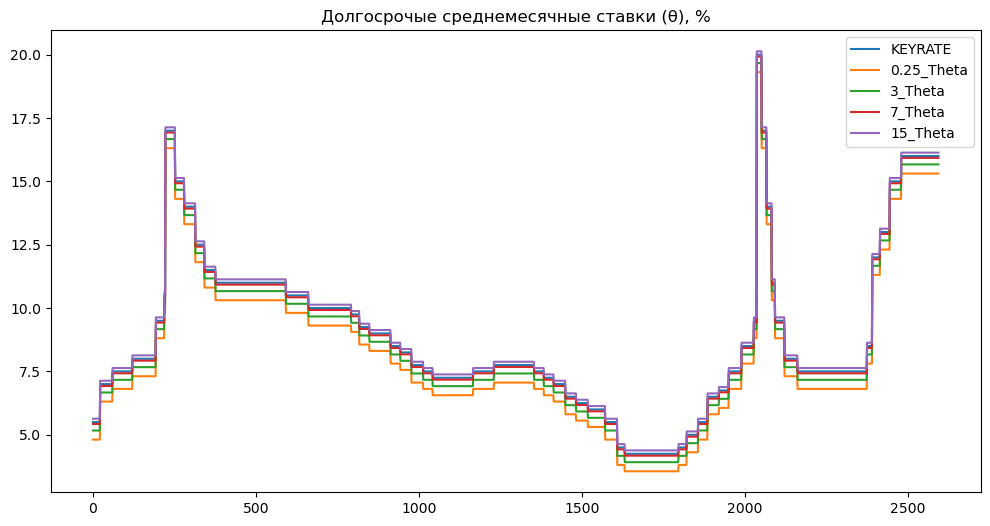

In [5]:
for t in tenors:
    g_curve_history[f'{t}_Theta'] = g_curve_history['KEYRATE'] - spreads[t]
    
g_curve_history.plot( y=['KEYRATE', '0.25_Theta', '3_Theta', '7_Theta', '15_Theta'], 
                     figsize=(12, 6), title='Долгосрочые среднемесячные ставки (θ), %')

# Калибровка моделей на истории

Распределение ставки в модели Халла-Уайта в общем случае:

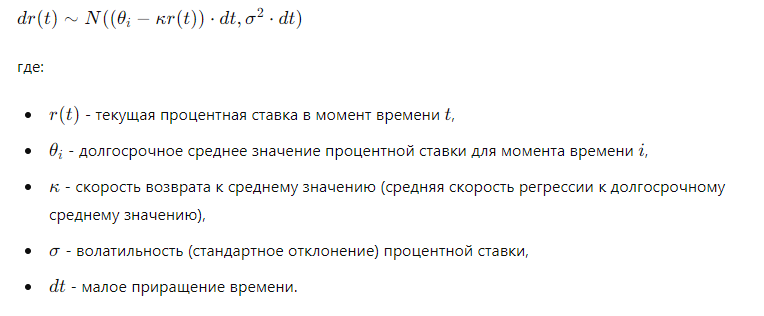

Чтобы не мучиться, kappa калибруется через МНК, θ берется из рассчетов выше:
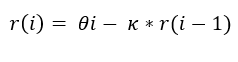
θ известна, преобразуем:
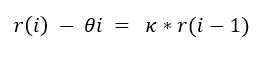
kappa калибруем МНК (переход к модельной kappa через 1 - kappa_МНК), σ считаем через дисперсию остатков:
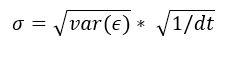

In [6]:
def calibrate_hw_parameters(r, floated_theta, dt):
    r_df = pd.DataFrame({'r': r})
    r_df['r_clear'] =  r - floated_theta.shift(1)
    r_df['r_lagged'] = r.shift(1)
    r_df = r_df.dropna()
    
    Y = r_df[['r_clear']]
    X = r_df[['r_lagged']]
    
    # МНК: (X.T * X)^(-1) * X.T * Y, переход к модельной kappa (1-Beta_МНК)
    kappa = (1+np.dot(np.dot(np.linalg.inv(np.dot(X.values.T, X.values)), X.values.T), Y.values))
    errors =  r_df['r'] -  kappa[0] * X['r_lagged']
    sigma = np.std(errors.values) * np.sqrt(1/dt)
    
    return kappa[0][0], sigma
    

In [7]:
params = {}

for t in tenors:
    params[t] = calibrate_hw_parameters(
        r = g_curve_history[t],
        floated_theta = g_curve_history[f'{t}_Theta'],
        dt = 1/252
    )
    
params

{'0.25': (0.985178040266341, 4.396749595978992),
 '0.5': (0.9838093244075345, 3.9509717428611033),
 '0.75': (0.983925465600483, 3.682739193353112),
 '1': (0.9842936269341686, 3.4971463094083384),
 '2': (0.9853832275262, 3.1162166222591914),
 '3': (0.9858272962476746, 2.9502922061495074),
 '5': (0.9866328605246899, 2.7833841695969213),
 '7': (0.9874261068920325, 2.6021564339645953),
 '10': (0.9882592636419931, 2.3542797778353),
 '15': (0.989160139694023, 2.2403989249756693),
 '20': (0.990150582358673, 2.262903411048706),
 '30': (0.9928249937015585, 2.4024071010742447)}

# Симуляция моделей и пронозирование КБД

Будем делать помесячный прогноз на до конца 2026 года. Cначала нужно задать θ. Рассмотрим два вида прогноза ключ. ставки:
* Бюджетный: Плавное ежеквартальное снижение ключ. ставки с августа 2024 до 7% до начала 2027
* Стрессовый 1: Резкое снижение в 2024, затем снова рост до 18%
* Стрессовый 2: Повышение ставки до 17% и начало снижения только с середины 2025


Для простоты - прогнозы в файлике

<AxesSubplot:title={'center':'Прогноз ключевой ставки, %'}, xlabel='DATE'>

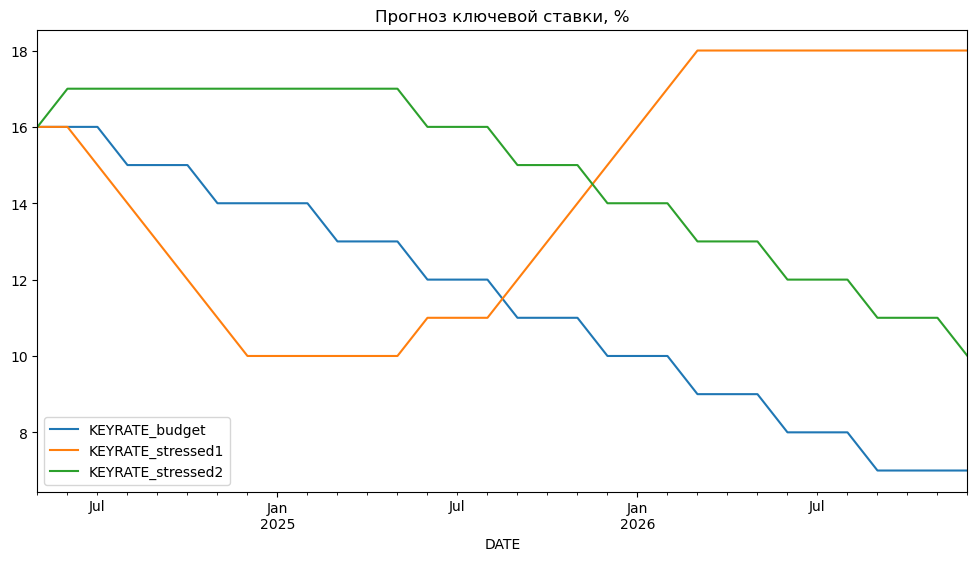

In [8]:
key_rate_pred = pd.read_excel('rub_keyrate.xlsx', sheet_name='KEYRATE_pred')
key_rate_pred.plot(x='DATE', y=['KEYRATE_budget', 'KEYRATE_stressed1', 'KEYRATE_stressed2'], 
                   figsize=(12, 6), title='Прогноз ключевой ставки, %')

In [9]:
# Рассчитываем teta для каждого сценария и тенора
tenors = ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']
theta_budget = pd.DataFrame()
for t in tenors:
    theta_budget[t] = key_rate_pred['KEYRATE_budget'] - spreads[t]
    
theta_stressed1 = pd.DataFrame()
for t in tenors:
    theta_stressed1[t] = key_rate_pred['KEYRATE_stressed1'] - spreads[t]
    
theta_stressed2 = pd.DataFrame()
for t in tenors:
    theta_stressed2[t] = key_rate_pred['KEYRATE_stressed2'] - spreads[t]

Напишем функцию для симуляции ставок. Также учитываем корреляции между ставками (делаем скоррелированные нормальные ошибки)

In [10]:
def simulate_rates(rates, tetha_array, params, n_paths, n_steps, T, seed=None):
    np.random.seed(seed)
    time = np.zeros(n_steps + 1) 
    dt = T / float(n_steps)
    
    # Делаем матрцу ошибок
    correlation_matrix = np.corrcoef(rates.values.T)
    print('Матрица корреляции ставок')
    display(pd.DataFrame(data=np.round(correlation_matrix, 2), index=list(rates), columns=list(rates)))
    
    error_array = np.random.multivariate_normal(mean=np.zeros(rates.shape[1]), cov=correlation_matrix, size=[n_paths,  n_steps])

    # Делаем матрицу ставок (для дальнейшей симуляции)
    rates_array = np.zeros([n_paths, n_steps + 1, rates.shape[1]])
    
    # Заполняем начало матрицы последними значениями ставок
    for r in range(rates.shape[1]):
        rates_array[:, 0, r] = rates.values[-1, r]
        
    # Cимулируем модель 
    m = 0
    for model in list(rates):
        print(f'Симулируем тенор {model}')
        kappa = params[model][0]
        sigma = params[model][1]
        for k in tqdm(range(0, n_steps)):
            rates_array[:,k+1,m] = rates_array[:,k,m]+(tetha_array[k][m]-kappa*rates_array[:,k,m])*dt+sigma*np.sqrt(dt)*error_array[:,k,m]
            time[k + 1] = time[k] + dt
        m+=1
        
    # Сохраняем модели в словарь    
    output = {'time': time}
    m=0
    for model in list(rates):
        output[model] = rates_array[:, :, m]
        m+=1
        
    del error_array, rates_array        
    return output

# Бюджетный сценарий ключевой ставки

In [11]:
# симулируем ставки для бюджетного сценария
budget_rates = simulate_rates(rates = temp[tenors], 
                              tetha_array = theta_budget.values, 
                              params=params, 
                              n_paths=1_000_000, # число симуляций каждой ставки
                              n_steps=31 , # число месяцев (шагов) до конца 2026
                              T=31/12, # срок симуляции в годах
                              seed=4221)

Матрица корреляции ставок


,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
0.25,1.00,1.00,0.99,0.98,0.95,0.93,0.90,0.87,0.84,0.82,0.80,0.76
0.5,1.00,1.00,1.00,0.99,0.98,0.96,0.92,0.90,0.87,0.84,0.81,0.77
0.75,0.99,1.00,1.00,1.00,0.99,0.97,0.94,0.91,0.88,0.85,0.83,0.78
1,0.98,0.99,1.00,1.00,0.99,0.98,0.95,0.92,0.89,0.86,0.83,0.78
2,0.95,0.98,0.99,0.99,1.00,1.00,0.98,0.96,0.93,0.89,0.86,0.80
3,0.93,0.96,0.97,0.98,1.00,1.00,0.99,0.97,0.95,0.91,0.88,0.81
5,0.90,0.92,0.94,0.95,0.98,0.99,1.00,1.00,0.98,0.95,0.92,0.85
7,0.87,0.90,0.91,0.92,0.96,0.97,1.00,1.00,0.99,0.97,0.95,0.88
10,0.84,0.87,0.88,0.89,0.93,0.95,0.98,0.99,1.00,0.99,0.97,0.92
15,0.82,0.84,0.85,0.86,0.89,0.91,0.95,0.97,0.99,1.00,0.99,0.96


Симулируем тенор 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.88it/s]


Симулируем тенор 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 19.08it/s]


Симулируем тенор 0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 20.78it/s]


Симулируем тенор 1


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 21.00it/s]


Симулируем тенор 2


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 20.56it/s]


Симулируем тенор 3


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.37it/s]


Симулируем тенор 5


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 21.16it/s]


Симулируем тенор 7


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 21.47it/s]


Симулируем тенор 10


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.51it/s]


Симулируем тенор 15


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 21.90it/s]


Симулируем тенор 20


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 20.19it/s]


Симулируем тенор 30


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.16it/s]


Посмотрим на график движения ставок некоторых теноров. Используем матожидание по симуляции в качестве прогноза.

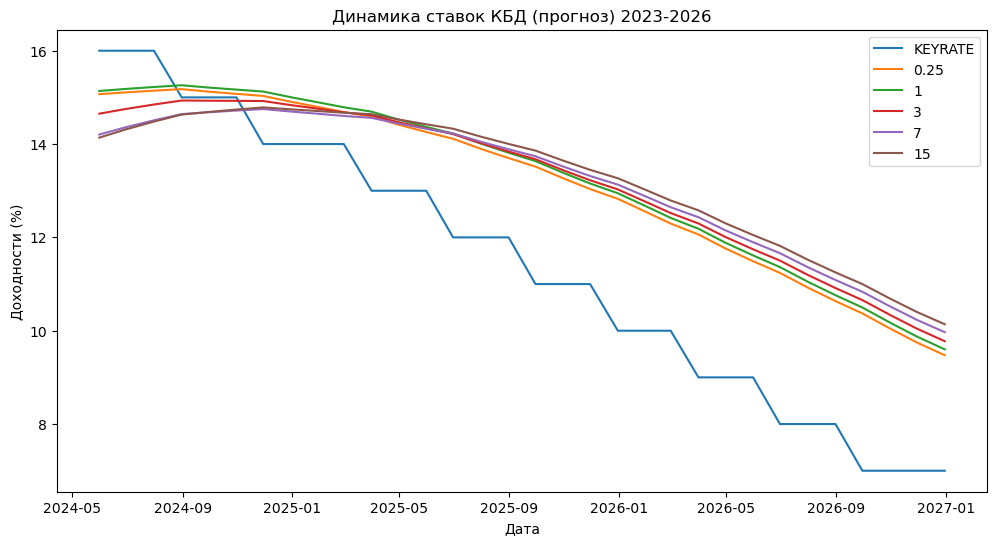

In [12]:
# В качестве прогноза бюджетного сценария возьмём матожидания ставок
plt.figure(figsize=(12,6))
plt.title('Динамика ставок КБД (прогноз) 2023-2026')
plt.plot(key_rate_pred['DATE'], key_rate_pred['KEYRATE_budget'], label='KEYRATE')
plt.plot(key_rate_pred['DATE'], np.mean(budget_rates['0.25'],  axis=0), label='0.25')
plt.plot(key_rate_pred['DATE'], np.mean(budget_rates['1'], axis=0), label='1')
plt.plot(key_rate_pred['DATE'], np.mean(budget_rates['3'],  axis=0), label='3')
plt.plot(key_rate_pred['DATE'], np.mean(budget_rates['7'],  axis=0), label='7')
plt.plot(key_rate_pred['DATE'], np.mean(budget_rates['15'], axis=0), label='15')

plt.xlabel('Дата')
plt.ylabel('Доходности (%)')
plt.legend()
plt.show()

Видно, что ставки стремятся к ключевой. Со временем происходит трансформация кривой в её нормально состояние (дляинные ставки выше коротких)


Теперь посмотрим на кривые КБД на конец 2024, 2025, 2026 годов.

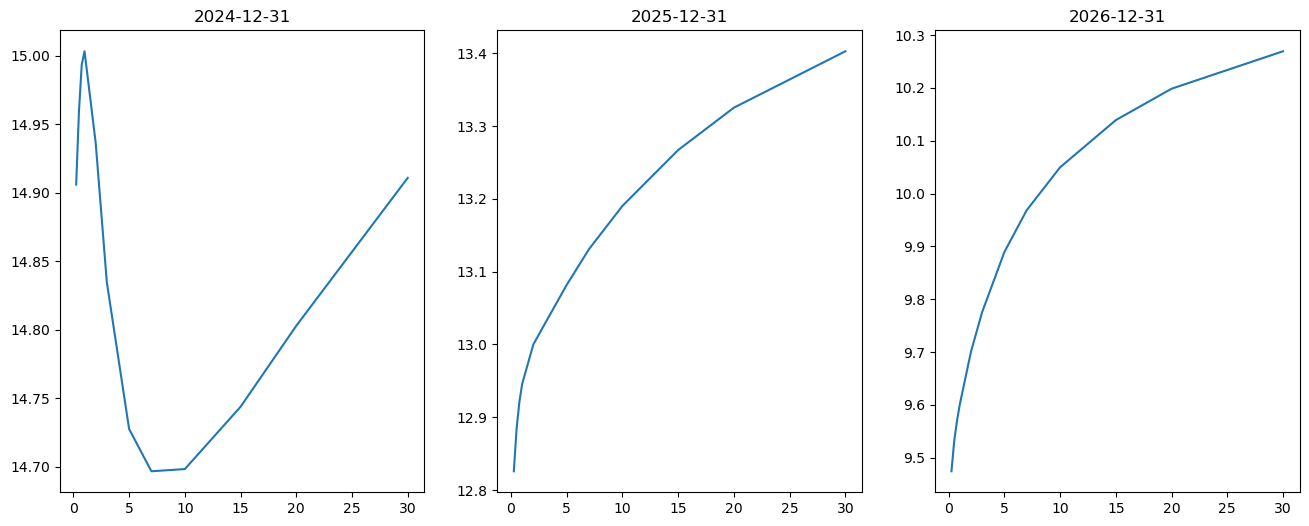

In [13]:
tenors_fig = [0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]
rates_2024 = []
rates_2025 = []
rates_2026 = []
for i in ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']:
    rates_2024.append(np.mean(budget_rates[i][:, 7]))
    rates_2025.append(np.mean(budget_rates[i][:, 19]))
    rates_2026.append(np.mean(budget_rates[i][:, 31]))
    


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
axs[0].plot(tenors_fig, rates_2024)
axs[0].set_title('2024-12-31')

axs[1].plot(tenors_fig, rates_2025)
axs[1].set_title('2025-12-31')

axs[2].plot(tenors_fig, rates_2026)
axs[2].set_title('2026-12-31')
plt.show()

# Стресс сценарий 1

In [14]:
# симулируем ставки для стрессового сценария
stressed_rates1 = simulate_rates(rates = temp[tenors], 
                              tetha_array = theta_stressed1.values, 
                              params=params, 
                              n_paths=1_000_000, # число симуляций каждой ставки
                              n_steps=31 , # число месяцев (шагов) до конца 2026
                              T=31/12, # срок симуляции в годах
                              seed=4221)

Матрица корреляции ставок


,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
0.25,1.00,1.00,0.99,0.98,0.95,0.93,0.90,0.87,0.84,0.82,0.80,0.76
0.5,1.00,1.00,1.00,0.99,0.98,0.96,0.92,0.90,0.87,0.84,0.81,0.77
0.75,0.99,1.00,1.00,1.00,0.99,0.97,0.94,0.91,0.88,0.85,0.83,0.78
1,0.98,0.99,1.00,1.00,0.99,0.98,0.95,0.92,0.89,0.86,0.83,0.78
2,0.95,0.98,0.99,0.99,1.00,1.00,0.98,0.96,0.93,0.89,0.86,0.80
3,0.93,0.96,0.97,0.98,1.00,1.00,0.99,0.97,0.95,0.91,0.88,0.81
5,0.90,0.92,0.94,0.95,0.98,0.99,1.00,1.00,0.98,0.95,0.92,0.85
7,0.87,0.90,0.91,0.92,0.96,0.97,1.00,1.00,0.99,0.97,0.95,0.88
10,0.84,0.87,0.88,0.89,0.93,0.95,0.98,0.99,1.00,0.99,0.97,0.92
15,0.82,0.84,0.85,0.86,0.89,0.91,0.95,0.97,0.99,1.00,0.99,0.96


Симулируем тенор 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.15it/s]


Симулируем тенор 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.65it/s]


Симулируем тенор 0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.02it/s]


Симулируем тенор 1


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.90it/s]


Симулируем тенор 2


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.02it/s]


Симулируем тенор 3


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.56it/s]


Симулируем тенор 5


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.74it/s]


Симулируем тенор 7


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.74it/s]


Симулируем тенор 10


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.94it/s]


Симулируем тенор 15


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.24it/s]


Симулируем тенор 20


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.51it/s]


Симулируем тенор 30


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.95it/s]


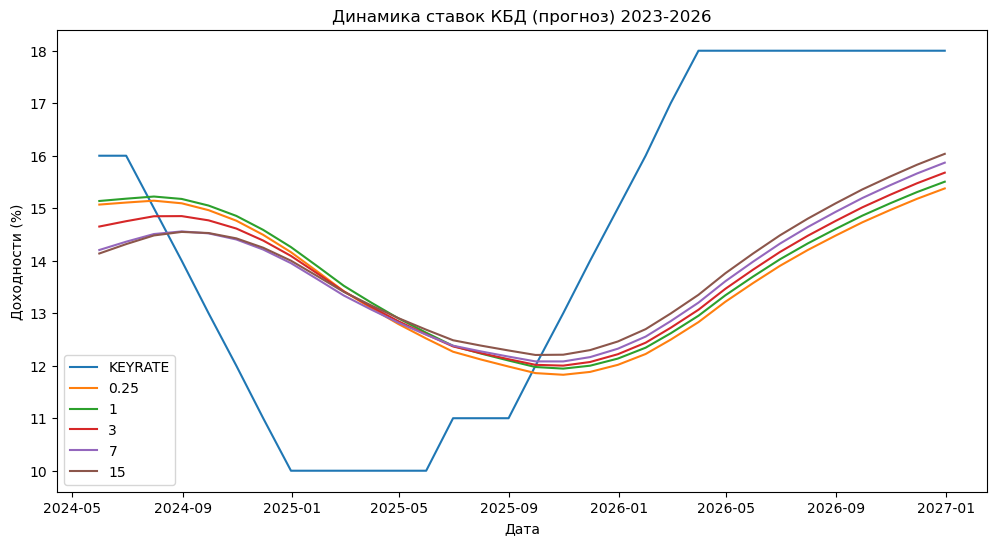

In [16]:
# В качестве прогноза  сценария возьмём матожидания ставок
plt.figure(figsize=(12,6))
plt.title('Динамика ставок КБД (прогноз) 2023-2026')
plt.plot(key_rate_pred['DATE'], key_rate_pred['KEYRATE_stressed1'], label='KEYRATE')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates1['0.25'],  axis=0), label='0.25')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates1['1'], axis=0), label='1')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates1['3'],  axis=0), label='3')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates1['7'],  axis=0), label='7')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates1['15'], axis=0), label='15')

plt.xlabel('Дата')
plt.ylabel('Доходности (%)')
plt.legend()
plt.show()

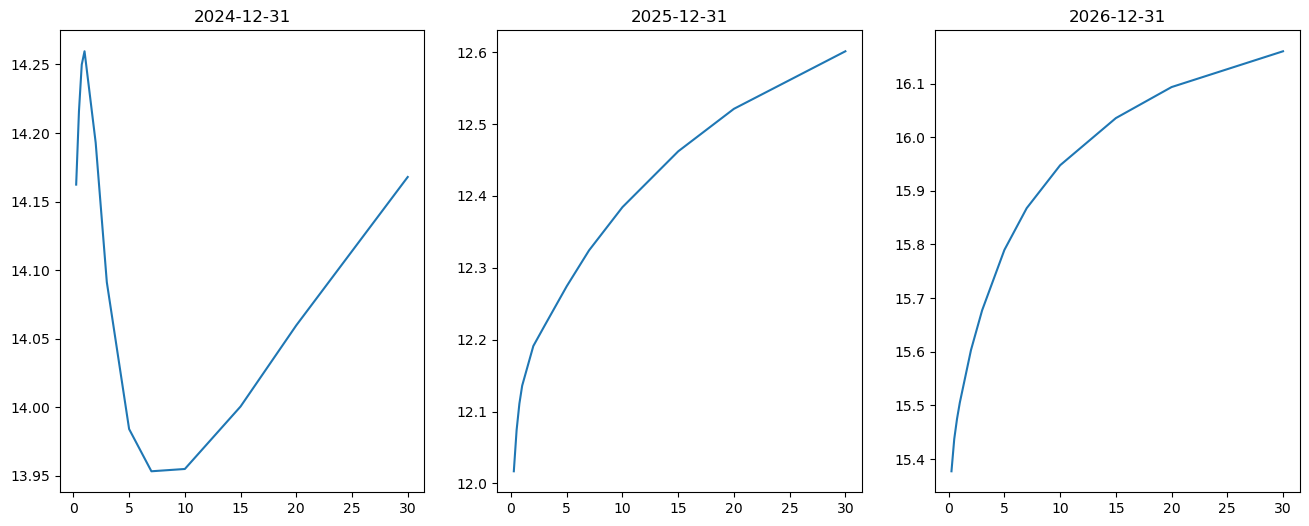

In [17]:
tenors_fig = [0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]
rates_2024 = []
rates_2025 = []
rates_2026 = []
for i in ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']:
    rates_2024.append(np.mean(stressed_rates1[i][:, 7]))
    rates_2025.append(np.mean(stressed_rates1[i][:, 19]))
    rates_2026.append(np.mean(stressed_rates1[i][:, 31]))
    


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
axs[0].plot(tenors_fig, rates_2024)
axs[0].set_title('2024-12-31')

axs[1].plot(tenors_fig, rates_2025)
axs[1].set_title('2025-12-31')

axs[2].plot(tenors_fig, rates_2026)
axs[2].set_title('2026-12-31')
plt.show()

# Стресс сценарий 2

In [19]:
# симулируем ставки для стрессового сценария
stressed_rates2 = simulate_rates(rates = temp[tenors], 
                              tetha_array = theta_stressed2.values, 
                              params=params, 
                              n_paths=1_000_000, # число симуляций каждой ставки
                              n_steps=31 , # число месяцев (шагов) до конца 2026
                              T=31/12, # срок симуляции в годах
                              seed=4221)

Матрица корреляции ставок


,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
0.25,1.00,1.00,0.99,0.98,0.95,0.93,0.90,0.87,0.84,0.82,0.80,0.76
0.5,1.00,1.00,1.00,0.99,0.98,0.96,0.92,0.90,0.87,0.84,0.81,0.77
0.75,0.99,1.00,1.00,1.00,0.99,0.97,0.94,0.91,0.88,0.85,0.83,0.78
1,0.98,0.99,1.00,1.00,0.99,0.98,0.95,0.92,0.89,0.86,0.83,0.78
2,0.95,0.98,0.99,0.99,1.00,1.00,0.98,0.96,0.93,0.89,0.86,0.80
3,0.93,0.96,0.97,0.98,1.00,1.00,0.99,0.97,0.95,0.91,0.88,0.81
5,0.90,0.92,0.94,0.95,0.98,0.99,1.00,1.00,0.98,0.95,0.92,0.85
7,0.87,0.90,0.91,0.92,0.96,0.97,1.00,1.00,0.99,0.97,0.95,0.88
10,0.84,0.87,0.88,0.89,0.93,0.95,0.98,0.99,1.00,0.99,0.97,0.92
15,0.82,0.84,0.85,0.86,0.89,0.91,0.95,0.97,0.99,1.00,0.99,0.96


Симулируем тенор 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.81it/s]


Симулируем тенор 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.44it/s]


Симулируем тенор 0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.59it/s]


Симулируем тенор 1


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.19it/s]


Симулируем тенор 2


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 15.45it/s]


Симулируем тенор 3


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.27it/s]


Симулируем тенор 5


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.12it/s]


Симулируем тенор 7


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.51it/s]


Симулируем тенор 10


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 19.19it/s]


Симулируем тенор 15


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.35it/s]


Симулируем тенор 20


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.19it/s]


Симулируем тенор 30


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.77it/s]


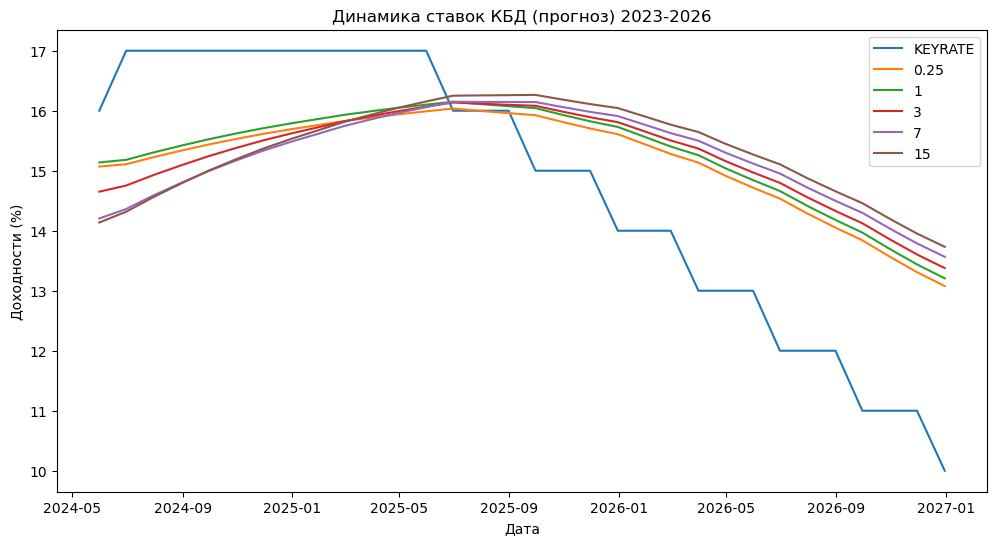

In [22]:
# В качестве прогноза  сценария возьмём матожидания ставок
plt.figure(figsize=(12,6))
plt.title('Динамика ставок КБД (прогноз) 2023-2026')
plt.plot(key_rate_pred['DATE'], key_rate_pred['KEYRATE_stressed2'], label='KEYRATE')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates2['0.25'],  axis=0), label='0.25')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates2['1'], axis=0), label='1')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates2['3'],  axis=0), label='3')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates2['7'],  axis=0), label='7')
plt.plot(key_rate_pred['DATE'], np.mean(stressed_rates2['15'], axis=0), label='15')

plt.xlabel('Дата')
plt.ylabel('Доходности (%)')
plt.legend()
plt.show()

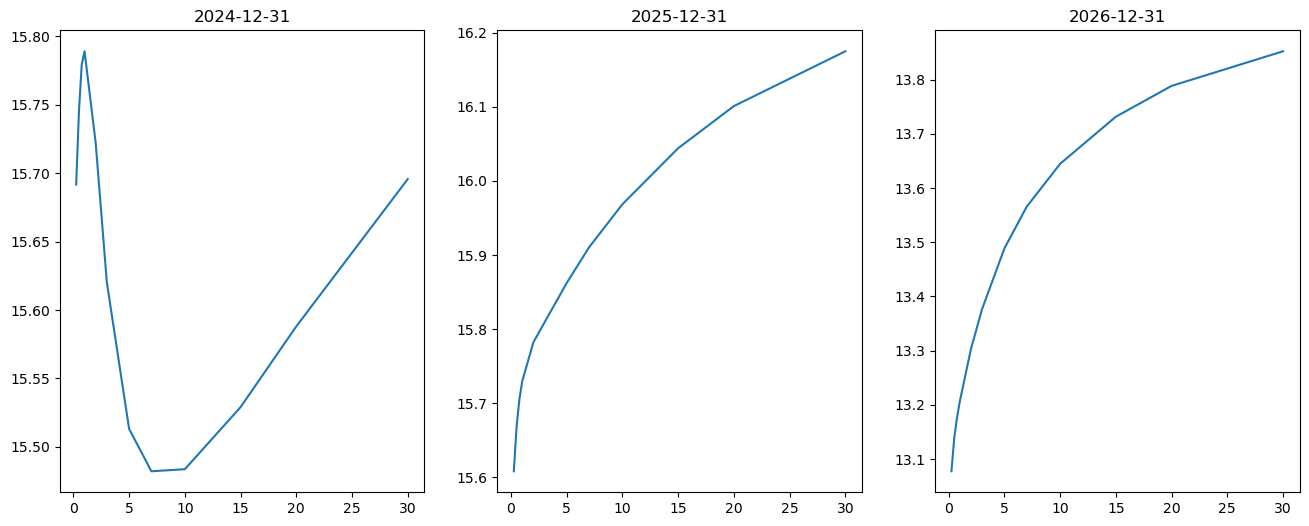

In [21]:
tenors_fig = [0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]
rates_2024 = []
rates_2025 = []
rates_2026 = []
for i in ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']:
    rates_2024.append(np.mean(stressed_rates2[i][:, 7]))
    rates_2025.append(np.mean(stressed_rates2[i][:, 19]))
    rates_2026.append(np.mean(stressed_rates2[i][:, 31]))
    


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
axs[0].plot(tenors_fig, rates_2024)
axs[0].set_title('2024-12-31')

axs[1].plot(tenors_fig, rates_2025)
axs[1].set_title('2025-12-31')

axs[2].plot(tenors_fig, rates_2026)
axs[2].set_title('2026-12-31')
plt.show()